In [1]:
import matplotlib.pyplot as plt
import pandas as pd

#### Functions

In [41]:
def try_cast_to_int_else_string(value):
    try:
        # Try to convert to integer
        return int(value)
    except ValueError:
        # If conversion fails, return as string
        return str(value)

## Prepping data

In [42]:
df = pd.read_csv("data/pizza_sales_with_data_quality_issues.csv")
df["order_date"] = pd.to_datetime(df["order_date"], format="%Y-%m-%d")
# Apply the function to the 'order_id' column
df['order_id'] = df['order_id'].apply(try_cast_to_int_else_string)

## 1) Outlying order dates

Outlying order dates in datasets are a common issue encountered during data analysis, especially in fields involving time-series or sequential data. These outliers can arise from various sources, such as data entry errors, system glitches, or incorrect data processing. They may manifest as dates that are significantly earlier or later than the rest of the data, or even as completely nonsensical dates (e.g., dates in the future for a supposedly historical dataset or dates well before the actual start of the dataset's timeframe). Identifying and addressing these outliers is crucial, as they can skew analysis, lead to incorrect conclusions, and affect model performance. Now, let's delve into examining outlying order dates in our dataset to understand their impact and decide on appropriate corrective actions. This process involves detecting these anomalies, assessing their nature, and determining the best course of action—whether it's correcting, removing, or otherwise accounting for these outliers in our analysis.

In [37]:
df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,first_name,second_name,address,date_of_birth
0,1.0,1.0,hawaiian_m,1.0,2015-01-01,11:38,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,Darren,Lambert,"360 Holland Pine Suite 597\r\nMartinezview, SC...",1943-04-24
1,2.0,2.0,classic_dlx_m,1.0,2015-01-01,11:57,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,Curtis,Clayton,"96436 Lisa Field\r\nEast John, DE 91152",1997-08-23
2,3.0,2.0,five_cheese_l,1.0,2015-01-01,11:57,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,Curtis,Clayton,"96436 Lisa Field\r\nEast John, DE 91152",1997-08-23
3,4.0,2.0,ital_supr_l,1.0,2015-01-01,11:57,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,Curtis,Clayton,"96436 Lisa Field\r\nEast John, DE 91152",1997-08-23
4,5.0,2.0,mexicana_m,1.0,2015-01-01,11:57,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,Curtis,Clayton,"96436 Lisa Field\r\nEast John, DE 91152",1997-08-23


#### Solution

In [43]:
df_1 = df.copy()
# Summarize orders by decade
df_1_decade_summary = (
    df_1.groupby(df["order_date"].dt.year // 10 * 10)
    .size()
    .reset_index(name="orders_count")
)
df_1_decade_summary

,order_date,orders_count
0,1700,2
1,1710,6
2,1720,6
3,1730,1
4,1740,4
5,1750,4
6,1760,4
7,1770,1
8,1780,1
9,1790,6


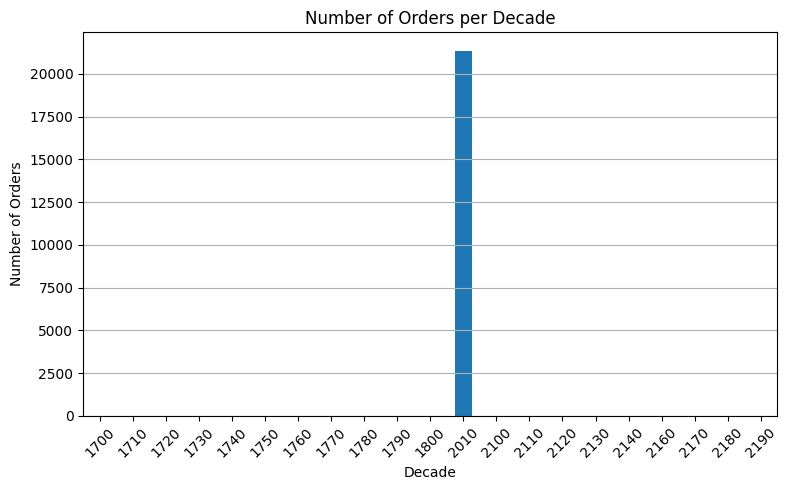

In [45]:
df_1["decade"] = (df_1["order_date"].dt.year // 10) * 10
# Count of orders per decade
orders_per_decade = df_1.groupby("decade")["order_id"].nunique()

# Plotting
plt.figure(figsize=(8, 5))
orders_per_decade.plot(kind="bar")
plt.title("Number of Orders per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

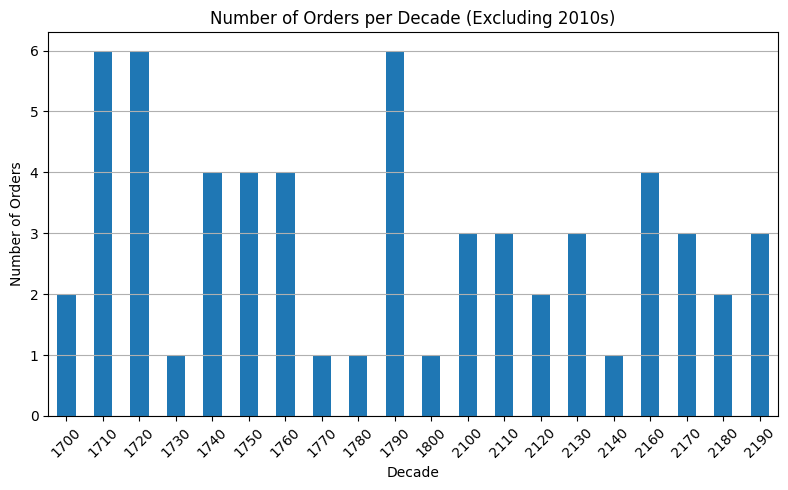

In [46]:
# Filtering the data to exclude the 2010 decade
orders_except_2010 = (
    df_1[df_1["decade"] != 2010].groupby("decade")["order_id"].nunique()
)

# Plotting
plt.figure(figsize=(8, 5))
orders_except_2010.plot(kind="bar")
plt.title("Number of Orders per Decade (Excluding 2010s)")
plt.xlabel("Decade")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

#### Conclusion 

In [7]:
# Remove outliers (assuming orders not in the decade of 2010s as outliers for the context of this example)
df_post_conclusion = df[df["order_date"].dt.year // 10 * 10 == 2010]

## 3) Misshapen values

In [47]:
df_3 = df.copy()

# Convert all 'order_id' to string to ensure consistent processing
df_3['order_id_str'] = df_3['order_id'].apply(str)

# Calculate the length of each 'order_id'
df_3['length'] = df_3['order_id_str'].apply(len)

# Group lengths exceeding 5 into a single category, ensuring all categories are strings
df_3['length_group'] = df_3['length'].apply(lambda x: str(x) if x <= 10 else '10+')

# Count occurrences of each length category
length_counts = df_3['length_group'].value_counts().sort_index()

length_counts

10+       85
3         42
4        211
5       2037
6      20930
7      26375
Name: length_group, dtype: int64

In [49]:
# Filtering rows where 'order_id' has more than 2 characters
filtered_df = df_3[df_3['length'] > 10]
filtered_df

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,first_name,second_name,address,date_of_birth,order_id_str,length,length_group
147,148.0,The Spinach Supreme Pizza,spinach_supr_m,1.0,2015-01-01,20:50,16.50,NaN,M,Supreme,NaN,NaN,Travis,Dixon,NaN,1989-05-05,The Spinach Supreme Pizza,25,10+
199,200.0,The Italian Supreme Pizza,NaN,1.0,2015-01-02,NaN,NaN,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",85.0,David,Miller,"312 Tyler Mills Suite 909\r\nBenitezshire, TN ...",1940-02-26,The Italian Supreme Pizza,25,10+
292,NaN,The Italian Capocollo Pizza,NaN,NaN,2015-01-02,20:12,12.00,12.00,NaN,Classic,"Capocollo, Red Peppers, Tomatoes, Goat Cheese,...",123.0,Monica,Thomas,"4229 Williams Field Suite 698\r\nWest Toni, HI...",1982-08-25,The Italian Capocollo Pizza,27,10+
1219,1220.0,The Classic Deluxe Pizza,NaN,1.0,2015-01-09,17:23,12.00,NaN,NaN,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",NaN,Raven,Bates,"75677 Woods Village\r\nLake Shelly, AZ 33231",1954-01-06,The Classic Deluxe Pizza,24,10+
1388,1389.0,The Spinach Pesto Pizza,spin_pesto_m,1.0,2015-01-10,20:31,16.50,NaN,M,Veggie,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",618.0,NaN,Faulkner,NaN,1963-01-06,The Spinach Pesto Pizza,23,10+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46779,46780.0,The California Chicken Pizza,cali_ckn_l,1.0,2015-12-15,17:15,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",20541.0,NaN,Robinson,"794 Leon Prairie\r\nPort Joseph, OK 01229",1945-07-29,The California Chicken Pizza,28,10+
47409,NaN,The Southwest Chicken Pizza,southw_ckn_m,1.0,2015-12-20,13:21,NaN,16.75,M,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja...",NaN,Tiffany,NaN,NaN,1990-05-12,The Southwest Chicken Pizza,27,10+
48489,48490.0,The Mexicana Pizza,mexicana_m,1.0,2015-12-31,14:52,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",21295.0,Vicki,NaN,"762 Sabrina Tunnel\r\nNew Jessicashire, AZ 14063",1953-10-22,The Mexicana Pizza,18,10+
49060,18537.0,The Napolitana Pizza,napolitana_s,1.0,2015-05-16,17:30,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",8138.0,NaN,Howard,"108 Summers Meadow\r\nEast Mark, DE 12468",1981-08-28,The Napolitana Pizza,20,10+
